In [1]:
import numpy as np
np.random.seed(42)
import pandas as pd
import torch
import torch.nn as nn
import plotly.express as px
import plotly.graph_objs as go
from rich.table import Table
from collections import namedtuple

Loaded ECG signal shape: (1000, 12)
Generated 100 windows for training.
Shape of X: (100, 800, 12), Shape of y: (100, 1200)


C:\Users\zain.hanif\AppData\Local\anaconda3\Lib\site-packages\keras\src\layers\convolutional\base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Model: "sequential_77"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv1d_159 (Conv1D)             │ (None, 798, 32)        │         1,184 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling1d_159               │ (None, 399, 32)        │             0 │
│ (MaxPooling1D)                  │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv1d_160 (Conv1D)             │ (None, 397, 64)        │         6,208 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling1d_160               │ (None, 198, 64)        │             0 │
│ (MaxPooling1D)                  │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ lstm_48 (LSTM)                  │ (None, 64)             │        33,024 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_210 (Dense)               │ (None, 128)            │         8,320 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_211 (Dense)               │ (None, 64)             │         8,256 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_212 (Dense)               │ (None, 1200)           │        78,000 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 134,992 (527.31 KB)

 Trainable params: 134,992 (527.31 KB)

 Non-trainable params: 0 (0.00 B)

Epoch 1/50
3/3 ━━━━━━━━━━━━━━━━━━━━ 7s 521ms/step - loss: 0.0118 - val_loss: 0.0114
Epoch 2/50
3/3 ━━━━━━━━━━━━━━━━━━━━ 1s 183ms/step - loss: 0.0118 - val_loss: 0.0113
Epoch 3/50
3/3 ━━━━━━━━━━━━━━━━━━━━ 1s 225ms/step - loss: 0.0117 - val_loss: 0.0112
Epoch 4/50
3/3 ━━━━━━━━━━━━━━━━━━━━ 1s 176ms/step - loss: 0.0114 - val_loss: 0.0111
Epoch 5/50
3/3 ━━━━━━━━━━━━━━━━━━━━ 1s 178ms/step - loss: 0.0113 - val_loss: 0.0109
Epoch 6/50
3/3 ━━━━━━━━━━━━━━━━━━━━ 1s 207ms/step - loss: 0.0111 - val_loss: 0.0109
Epoch 7/50
3/3 ━━━━━━━━━━━━━━━━━━━━ 1s 215ms/step - loss: 0.0110 - val_loss: 0.0108
Epoch 8/50
3/3 ━━━━━━━━━━━━━━━━━━━━ 1s 177ms/step - loss: 0.0110 - val_loss: 0.0107
Epoch 9/50
3/3 ━━━━━━━━━━━━━━━━━━━━ 1s 179ms/step - loss: 0.0108 - val_loss: 0.0106
Epoch 10/50
3/3 ━━━━━━━━━━━━━━━━━━━━ 1s 179ms/step - loss: 0.0108 - val_loss: 0.0106
Epoch 11/50
3/3 ━━━━━━━━━━━━━━━━━━━━ 1s 197ms/step - loss: 0.0106 - val_loss: 0.0106
Epoch 12/50
3/3 ━━━━━━━━━━━━━━━━━━━━ 1s 172ms/step - loss: 0.0107 - val_lo

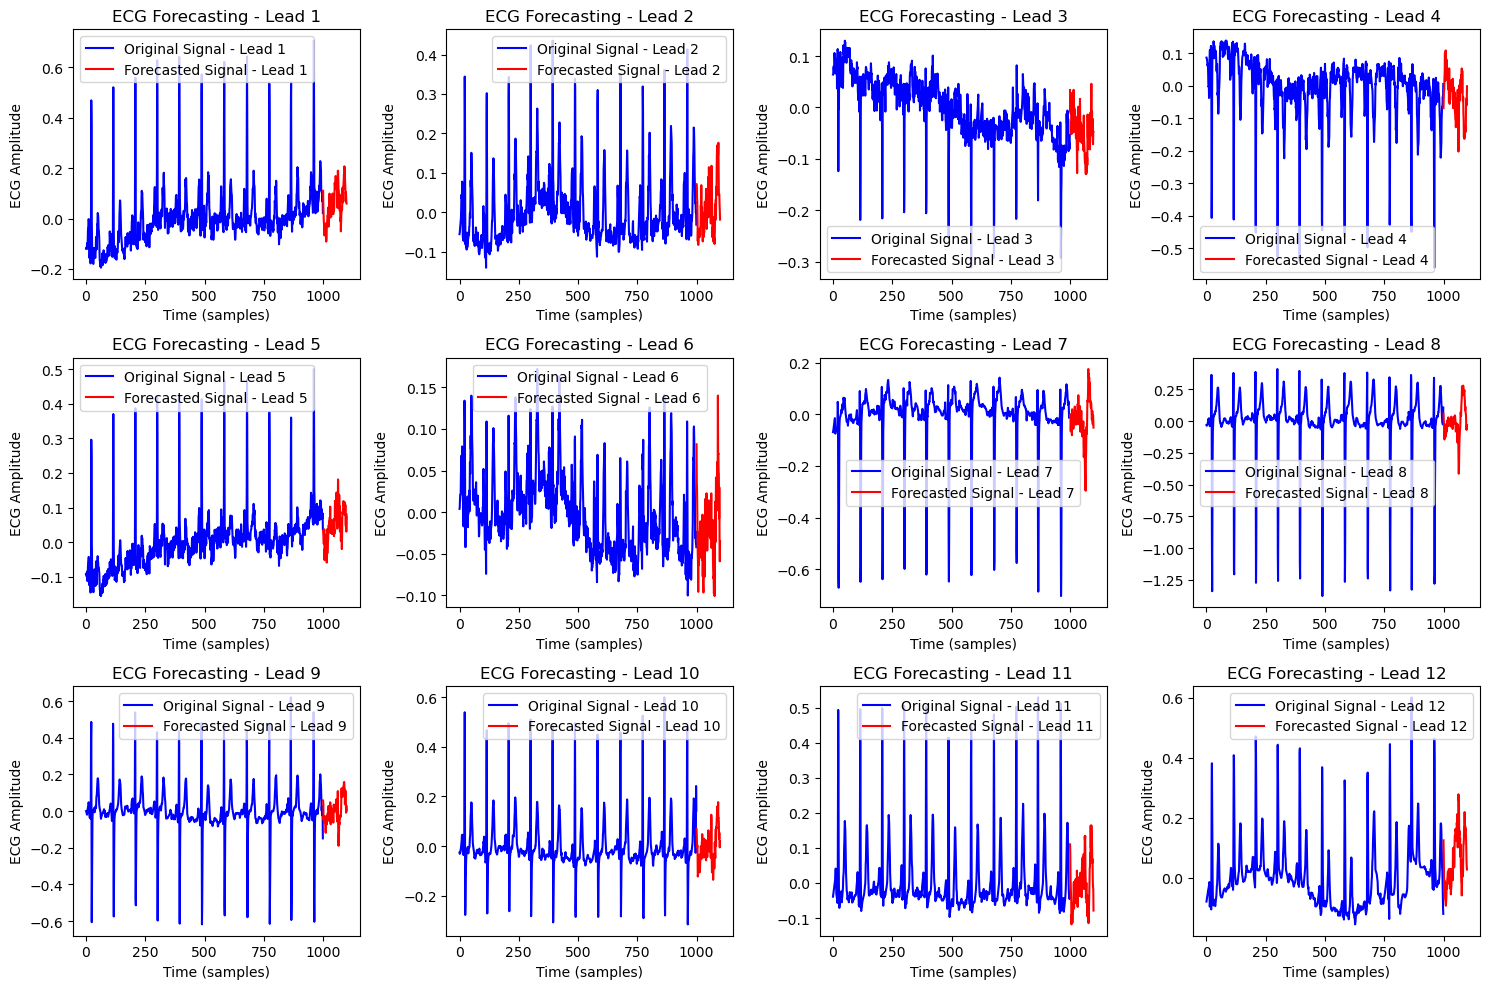

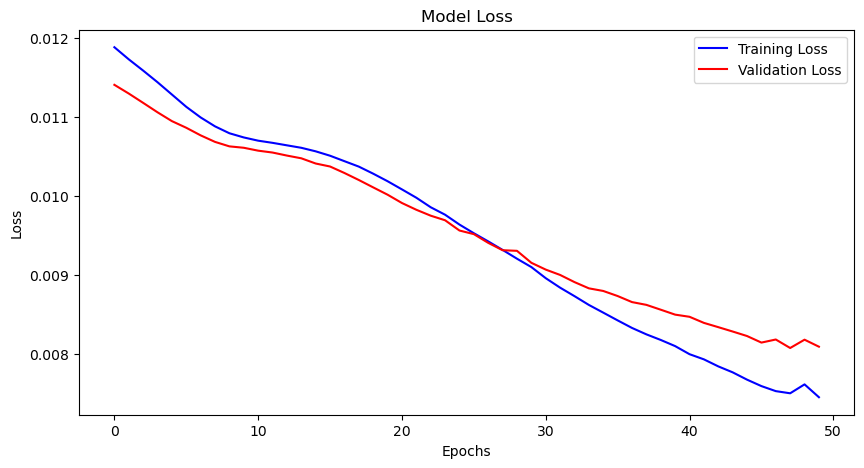

In [310]:
#CNN-LSTM MODEL For 1 Patient

import os
import pandas as pd
import numpy as np
import wfdb
import matplotlib.pyplot as plt
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv1D, MaxPooling1D, LSTM, Dense
from sklearn.model_selection import train_test_split

# Load and preprocess the ECG data
metadata_file = r"C:\Users\zain.hanif\Desktop\University\HIS Project\ptb-xl-a-large-publicly-available-electrocardiography-dataset-1.0.3\ptbxl_database.csv"
base_path = r"C:\Users\zain.hanif\Desktop\University\HIS Project\ptb-xl-a-large-publicly-available-electrocardiography-dataset-1.0.3"

df = pd.read_csv(metadata_file)
patient_id = 15709
df_patient = df[df['patient_id'] == patient_id]

ecg_data = []
for _, row in df_patient.iterrows():
    ecg_path_lr = os.path.join(base_path, row['filename_lr'])
    try:
        record = wfdb.rdrecord(ecg_path_lr.replace('.dat', ''), sampto=1000) 
        ecg_signal_lr = record.p_signal[:, :12] 
        ecg_data.append(ecg_signal_lr)
    except FileNotFoundError:
        print(f"File not found: {ecg_path_lr}")


if ecg_data:
    ecg_signal = np.array(ecg_data[0]) 
    print(f"Loaded ECG signal shape: {ecg_signal.shape}")
else:
    print("No ECG data loaded. Please check the file paths.")
    exit()

window_size = 800  
forecast_horizon = 100  

def create_forecasting_windows(ecg_signal, window_size, forecast_horizon):
    if len(ecg_signal) <= window_size + forecast_horizon:
        raise ValueError(f"Signal length ({len(ecg_signal)}) is too short for the given window size ({window_size}) "
                         f"and forecast horizon ({forecast_horizon}).")
    X, y = [], []
    for i in range(len(ecg_signal) - window_size - forecast_horizon):
        X.append(ecg_signal[i : i + window_size])  # Input window
        y.append(ecg_signal[i + window_size : i + window_size + forecast_horizon])  # Forecast target
    return np.array(X), np.array(y)

X, y = create_forecasting_windows(ecg_signal, window_size, forecast_horizon)

X = X 

# Reshape y to have the correct shape of (samples, forecast_horizon * 12)
y = y.reshape((y.shape[0], forecast_horizon * 12))

print(f"Generated {len(X)} windows for training.")
print(f"Shape of X: {X.shape}, Shape of y: {y.shape}")

# Build the CNN-LSTM model for 12 leads
def build_cnn_lstm_model(input_shape):
    model = Sequential()
    # CNN layers
    model.add(Conv1D(filters=32, kernel_size=3, activation='relu', input_shape=input_shape))
    model.add(MaxPooling1D(pool_size=2))
    model.add(Conv1D(filters=64, kernel_size=3, activation='relu'))
    model.add(MaxPooling1D(pool_size=2))
    
    # LSTM Layer - No Flatten before LSTM
    model.add(LSTM(64, activation='relu', return_sequences=False))
    
    # Dense layers
    model.add(Dense(128, activation='relu'))
    model.add(Dense(64, activation='relu'))
    model.add(Dense(forecast_horizon * 12, activation='linear'))  # Forecasting 12 leads for forecast horizon
    
    model.compile(optimizer='adam', loss='mse')
    return model

# Define input shape (window_size, 12 leads)
input_shape = (window_size, 12)
model = build_cnn_lstm_model(input_shape)
model.summary()

# Train the model
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)
history = model.fit(X_train, y_train, validation_data=(X_test, y_test), epochs=50, batch_size=32)

# Forecasting
last_window = ecg_signal[-window_size:]
last_window = last_window[np.newaxis, ...]  # Add batch dimension
# Ensure the shape of last_window is (1, window_size, 12)
next_prediction = model.predict(last_window)

# Reshape prediction to (forecast_horizon, 12) for visualization
next_prediction = next_prediction.reshape(forecast_horizon, 12)

# Visualization for all 12 leads
plt.figure(figsize=(15, 10))
for i in range(12):  # Plot each of the 12 leads
    plt.subplot(3, 4, i + 1)  # 3 rows, 4 columns of subplots
    plt.plot(range(len(ecg_signal)), ecg_signal[:, i], label=f"Original Signal - Lead {i+1}", color='blue')
    plt.plot(range(len(ecg_signal), len(ecg_signal) + forecast_horizon), next_prediction[:, i], label=f"Forecasted Signal - Lead {i+1}", color='red')
    plt.title(f"ECG Forecasting - Lead {i+1}")
    plt.xlabel("Time (samples)")
    plt.ylabel("ECG Amplitude")
    plt.legend()

plt.tight_layout()
plt.show()

# Plot training & validation loss values
plt.figure(figsize=(10, 5))
plt.plot(history.history['loss'], label='Training Loss', color='blue')
plt.plot(history.history['val_loss'], label='Validation Loss', color='red')
plt.title('Model Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.show()


Loaded ECG signal shape for patient 15709: (1, 1000, 12)
Generated 100 windows for training.
Shape of X: (100, 800, 12), Shape of y: (100, 1200)


C:\Users\zain.hanif\AppData\Local\anaconda3\Lib\site-packages\keras\src\layers\convolutional\base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Epoch 1/300
2/2 ━━━━━━━━━━━━━━━━━━━━ 11s 1s/step - loss: 1.5230 - val_loss: 1.6763
Epoch 2/300
2/2 ━━━━━━━━━━━━━━━━━━━━ 1s 279ms/step - loss: 1.5057 - val_loss: 1.6602
Epoch 3/300
2/2 ━━━━━━━━━━━━━━━━━━━━ 1s 280ms/step - loss: 1.4886 - val_loss: 1.6441
Epoch 4/300
2/2 ━━━━━━━━━━━━━━━━━━━━ 1s 277ms/step - loss: 1.4643 - val_loss: 1.6279
Epoch 5/300
2/2 ━━━━━━━━━━━━━━━━━━━━ 1s 280ms/step - loss: 1.4455 - val_loss: 1.6113
Epoch 6/300
2/2 ━━━━━━━━━━━━━━━━━━━━ 1s 317ms/step - loss: 1.4249 - val_loss: 1.5944
Epoch 7/300
2/2 ━━━━━━━━━━━━━━━━━━━━ 1s 295ms/step - loss: 1.4001 - val_loss: 1.5771
Epoch 8/300
2/2 ━━━━━━━━━━━━━━━━━━━━ 1s 283ms/step - loss: 1.3821 - val_loss: 1.5594
Epoch 9/300
2/2 ━━━━━━━━━━━━━━━━━━━━ 1s 295ms/step - loss: 1.3539 - val_loss: 1.5414
Epoch 10/300
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 277ms/step - loss: 1.3308 - val_loss: 1.5234
Epoch 11/300
2/2 ━━━━━━━━━━━━━━━━━━━━ 1s 290ms/step - loss: 1.3073 - val_loss: 1.5058
Epoch 12/300
2/2 ━━━━━━━━━━━━━━━━━━━━ 1s 331ms/step - loss: 1.279

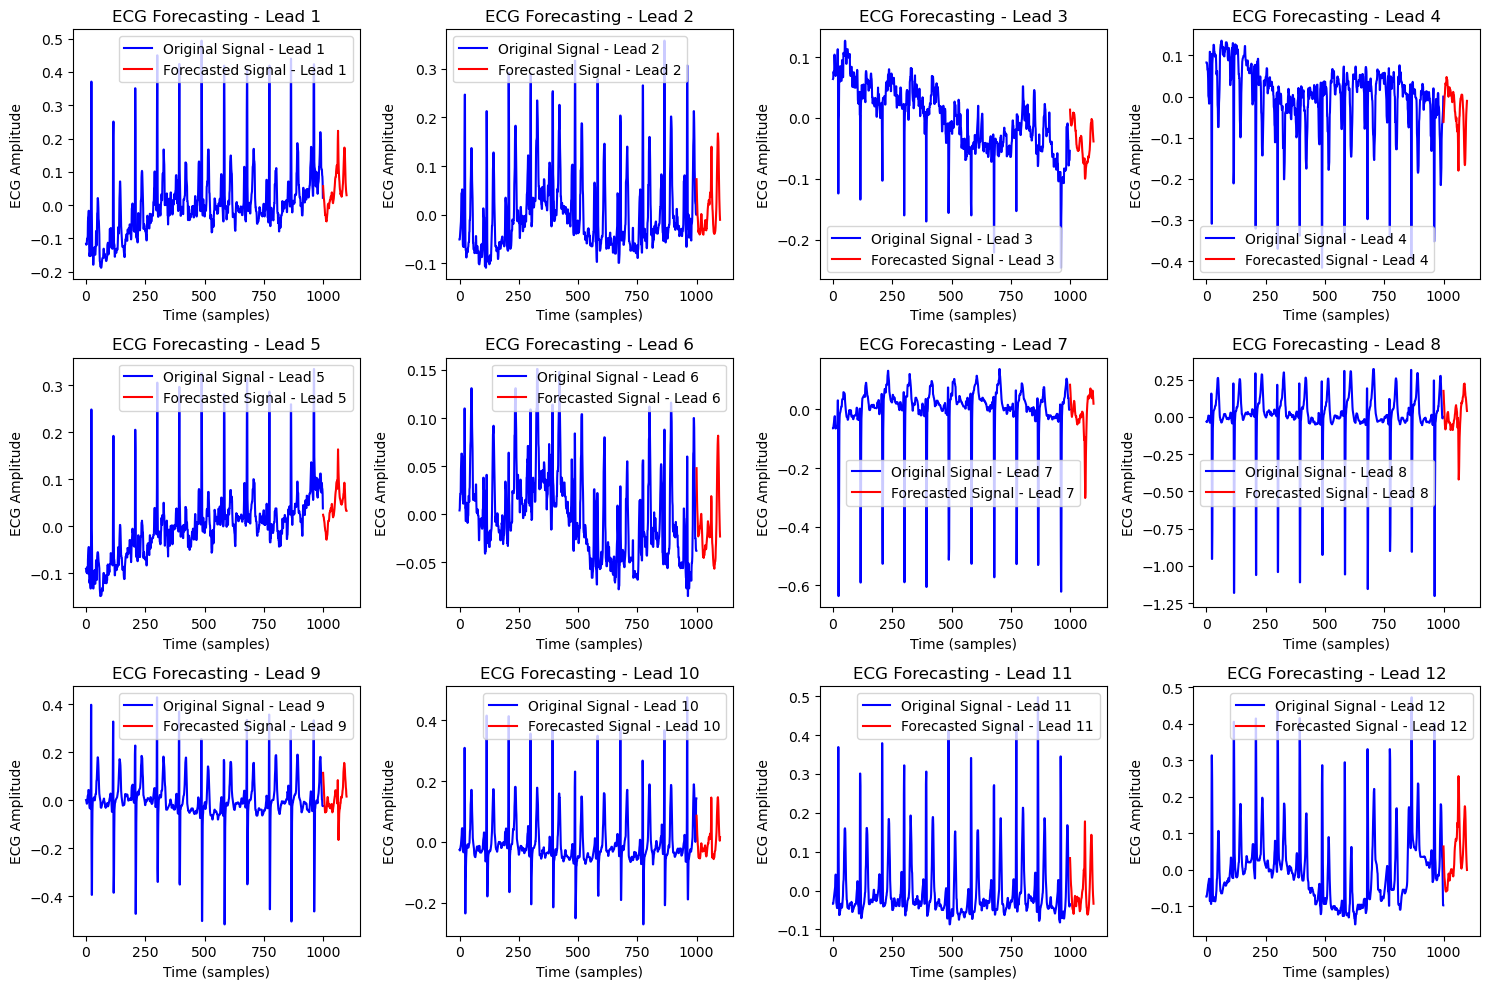

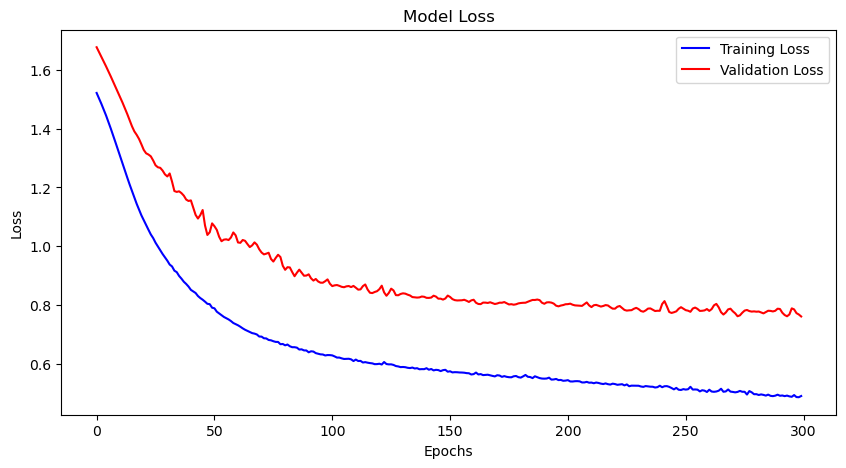

In [283]:
import os
import pandas as pd
import numpy as np
import wfdb
import matplotlib.pyplot as plt
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv1D, MaxPooling1D, LSTM, Dense, Dropout, BatchNormalization
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler  # Use StandardScaler
from tensorflow.keras.callbacks import EarlyStopping
from scipy.signal import medfilt
from sklearn.metrics import mean_absolute_error, mean_squared_error

# Data Loading and Preprocessing
metadata_file = r"C:\Users\zain.hanif\Desktop\University\HIS Project\ptb-xl-a-large-publicly-available-electrocardiography-dataset-1.0.3\ptbxl_database.csv"  # Replace with your path
base_path = r"C:\Users\zain.hanif\Desktop\University\HIS Project\ptb-xl-a-large-publicly-available-electrocardiography-dataset-1.0.3"  # Replace with your path

df = pd.read_csv(metadata_file)
patient_id = 15709  # YOUR SPECIFIC PATIENT ID

df_patient = df[df['patient_id'] == patient_id]  # Filter for the specific patient

ecg_data = []
for _, row in df_patient.iterrows():  # Iterate over the patient's records
    ecg_path_lr = os.path.join(base_path, row['filename_lr'])
    try:
        record = wfdb.rdrecord(ecg_path_lr.replace('.dat', ''))

        # Dynamic sampto: Read all available samples, or up to max_len
        max_len = 2000  # Your desired maximum length
        actual_len = record.sig_len  # Actual length of the signal
        sampto = min(max_len, actual_len)  # Take the smaller of the two

        record = wfdb.rdrecord(ecg_path_lr.replace('.dat', ''), sampto=sampto)  # Read with correct sampto
        ecg_signal_lr = record.p_signal[:, :12]
        ecg_data.append(ecg_signal_lr)
    except FileNotFoundError:
        print(f"File not found: {ecg_path_lr}")
    except ValueError as e:  # Catch potential other ValueErrors too
        print(f"Error reading record {ecg_path_lr}: {e}")

if not ecg_data:
    print("No ECG data loaded for this patient. Please check the file paths and patient ID.")
    exit()

ecg_signal = np.array(ecg_data)  # Now ecg_signal is (num_records, time_steps, leads)
print(f"Loaded ECG signal shape for patient {patient_id}: {ecg_signal.shape}")

window_size = 800
forecast_horizon = 100

def create_forecasting_windows(ecg_signal, window_size, forecast_horizon):
    X, y = [], []
    num_records = ecg_signal.shape[0]  # Number of ECG records
    time_steps = ecg_signal.shape[1]  # Number of time steps in each record
    for record_idx in range(num_records):  # Iterate over each record
        for i in range(time_steps - window_size - forecast_horizon):  # Iterate over time steps within each record
            X.append(ecg_signal[record_idx, i: i + window_size])  # Use all leads for the window
            y.append(ecg_signal[record_idx, i + window_size: i + window_size + forecast_horizon])  # Forecast all leads
    return np.array(X), np.array(y)

# --- Signal Filtering (Median Filter) ---
for i in range(ecg_signal.shape[0]):  # Filter each record
    for j in range(12):  # Filter each lead
        ecg_signal[i, :, j] = medfilt(ecg_signal[i, :, j], kernel_size=3)  # Adjust kernel_size

X, y = create_forecasting_windows(ecg_signal, window_size, forecast_horizon)

# Reshape X and y (important for multiple records)
X = X.reshape(-1, window_size, 12)  # Reshape to (samples, window_size, 12)
y = y.reshape(-1, forecast_horizon * 12)  # Reshape to (samples, forecast_horizon * 12)

print(f"Generated {len(X)} windows for training.")
print(f"Shape of X: {X.shape}, Shape of y: {y.shape}")

# Data Splitting (Keep this for evaluating the model)
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Normalization (Crucial! - AFTER splitting)
scaler_X = StandardScaler()  # Use StandardScaler
X_train = scaler_X.fit_transform(X_train.reshape(X_train.shape[0], -1)).reshape(X_train.shape)  # Fit and transform training data
X_test = scaler_X.transform(X_test.reshape(X_test.shape[0], -1)).reshape(X_test.shape)  # Transform test data using the fitted scaler

scaler_y = StandardScaler()  # Use StandardScaler
y_train = scaler_y.fit_transform(y_train)
y_test = scaler_y.transform(y_test)

# --- Model Building (Improved with Regularization and Batch Normalization) ---
input_shape = (window_size, 12)

def build_cnn_lstm_model(input_shape, forecast_horizon):
    model = Sequential()
    model.add(Conv1D(filters=32, kernel_size=5, activation='relu', input_shape=input_shape))  # Reduced filters
    model.add(BatchNormalization())  # Batch Normalization
    model.add(MaxPooling1D(pool_size=2))
    model.add(Conv1D(filters=64, kernel_size=3, activation='relu'))  # Reduced filters
    model.add(BatchNormalization())  # Batch Normalization
    model.add(MaxPooling1D(pool_size=2))
    model.add(Dropout(0.4))  # Increased dropout

    model.add(LSTM(64, activation='tanh', return_sequences=True))  # Reduced LSTM units
    model.add(Dropout(0.4))  # Increased dropout
    model.add(LSTM(32, activation='tanh'))  # Reduced LSTM units

    model.add(Dense(128, activation='relu', kernel_regularizer='l2'))  # L2 regularization
    model.add(Dense(forecast_horizon * 12, activation='linear'))

    model.compile(optimizer='adam', loss='mse')  # Or try MAE: loss='mae'
    return model

model = build_cnn_lstm_model(input_shape, forecast_horizon)

# --- Training ---
early_stopping = EarlyStopping(monitor='val_loss', patience=30, restore_best_weights=True)  # Increased patience

history = model.fit(X_train, y_train, validation_data=(X_test, y_test),
                    epochs=300, batch_size=64,  # Increased batch size
                    callbacks=[early_stopping])

# Forecasting
last_window = ecg_signal[0, -window_size:]  # Last window from the FIRST record of the patient.
last_window = last_window[np.newaxis, ...]  # Add batch dimension

last_window_scaled = scaler_X.transform(last_window.reshape(1, -1)).reshape(last_window.shape)

next_prediction = model.predict(last_window_scaled)

next_prediction = scaler_y.inverse_transform(next_prediction).reshape(forecast_horizon, 12)

print("X_train shape:", X_train.shape)

print("X_test shape:", X_test.shape)

print("y_train shape:", y_train.shape)

print("y_test shape:", y_test.shape)



print("X_train min:", X_train.min())

print("X_train max:", X_train.max())

print("X_test min:", X_test.min())

print("X_test max:", X_test.max())



print("y_train min:", y_train.min())

print("y_train max:", y_train.max())

print("y_test min:", y_test.min())

print("y_test max:", y_test.max())



print("NaN in X_train:", np.isnan(X_train).any())

print("Inf in X_train:", np.isinf(X_train).any())

print("NaN in X_test:", np.isnan(X_test).any())

print("Inf in X_test:", np.isinf(X_test).any())

print("NaN in y_train:", np.isnan(y_train).any())

print("Inf in y_train:", np.isinf(y_train).any())

print("NaN in y_test:", np.isnan(y_test).any())

print("Inf in y_test:", np.isinf(y_test).any())

# Visualization for all 12 leads (using the first record for visualization)
plt.figure(figsize=(15, 10))
for i in range(12):  # Plot each of the 12 leads
    plt.subplot(3, 4, i + 1)  # 3 rows, 4 columns of subplots
    plt.plot(range(ecg_signal.shape[1]), ecg_signal[0, :, i], label=f"Original Signal - Lead {i+1}", color='blue')  # Use ecg_signal[0] for the first record
    plt.plot(range(ecg_signal.shape[1], ecg_signal.shape[1] + forecast_horizon), next_prediction[:, i], label=f"Forecasted Signal - Lead {i+1}", color='red')
    plt.title(f"ECG Forecasting - Lead {i+1}")
    plt.xlabel("Time (samples)")
    plt.ylabel("ECG Amplitude")
    plt.legend()

plt.tight_layout()
plt.show()

# Plot training & validation loss values
plt.figure(figsize=(10, 5))
plt.plot(history.history['loss'], label='Training Loss', color='blue')
plt.plot(history.history['val_loss'], label='Validation Loss', color='red')
plt.title('Model Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.show()

Loaded ECG signal shape for patient 15709: (1, 1000, 12)
Generated 100 windows for training.
Shape of X: (100, 800, 12), Shape of y: (100, 1200)


C:\Users\zain.hanif\AppData\Local\anaconda3\Lib\site-packages\keras\src\layers\convolutional\base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Epoch 1/100
2/2 ━━━━━━━━━━━━━━━━━━━━ 11s 1s/step - loss: 1.5084 - val_loss: 1.6630
Epoch 2/100
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 267ms/step - loss: 1.4922 - val_loss: 1.6473
Epoch 3/100
2/2 ━━━━━━━━━━━━━━━━━━━━ 1s 268ms/step - loss: 1.4758 - val_loss: 1.6316
Epoch 4/100
2/2 ━━━━━━━━━━━━━━━━━━━━ 1s 261ms/step - loss: 1.4575 - val_loss: 1.6159
Epoch 5/100
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 253ms/step - loss: 1.4392 - val_loss: 1.6000
Epoch 6/100
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 255ms/step - loss: 1.4153 - val_loss: 1.5837
Epoch 7/100
2/2 ━━━━━━━━━━━━━━━━━━━━ 1s 280ms/step - loss: 1.3971 - val_loss: 1.5672
Epoch 8/100
2/2 ━━━━━━━━━━━━━━━━━━━━ 1s 304ms/step - loss: 1.3754 - val_loss: 1.5505
Epoch 9/100
2/2 ━━━━━━━━━━━━━━━━━━━━ 1s 251ms/step - loss: 1.3511 - val_loss: 1.5333
Epoch 10/100
2/2 ━━━━━━━━━━━━━━━━━━━━ 1s 262ms/step - loss: 1.3333 - val_loss: 1.5150
Epoch 11/100
2/2 ━━━━━━━━━━━━━━━━━━━━ 1s 292ms/step - loss: 1.3084 - val_loss: 1.4956
Epoch 12/100
2/2 ━━━━━━━━━━━━━━━━━━━━ 1s 279ms/step - loss: 1.283

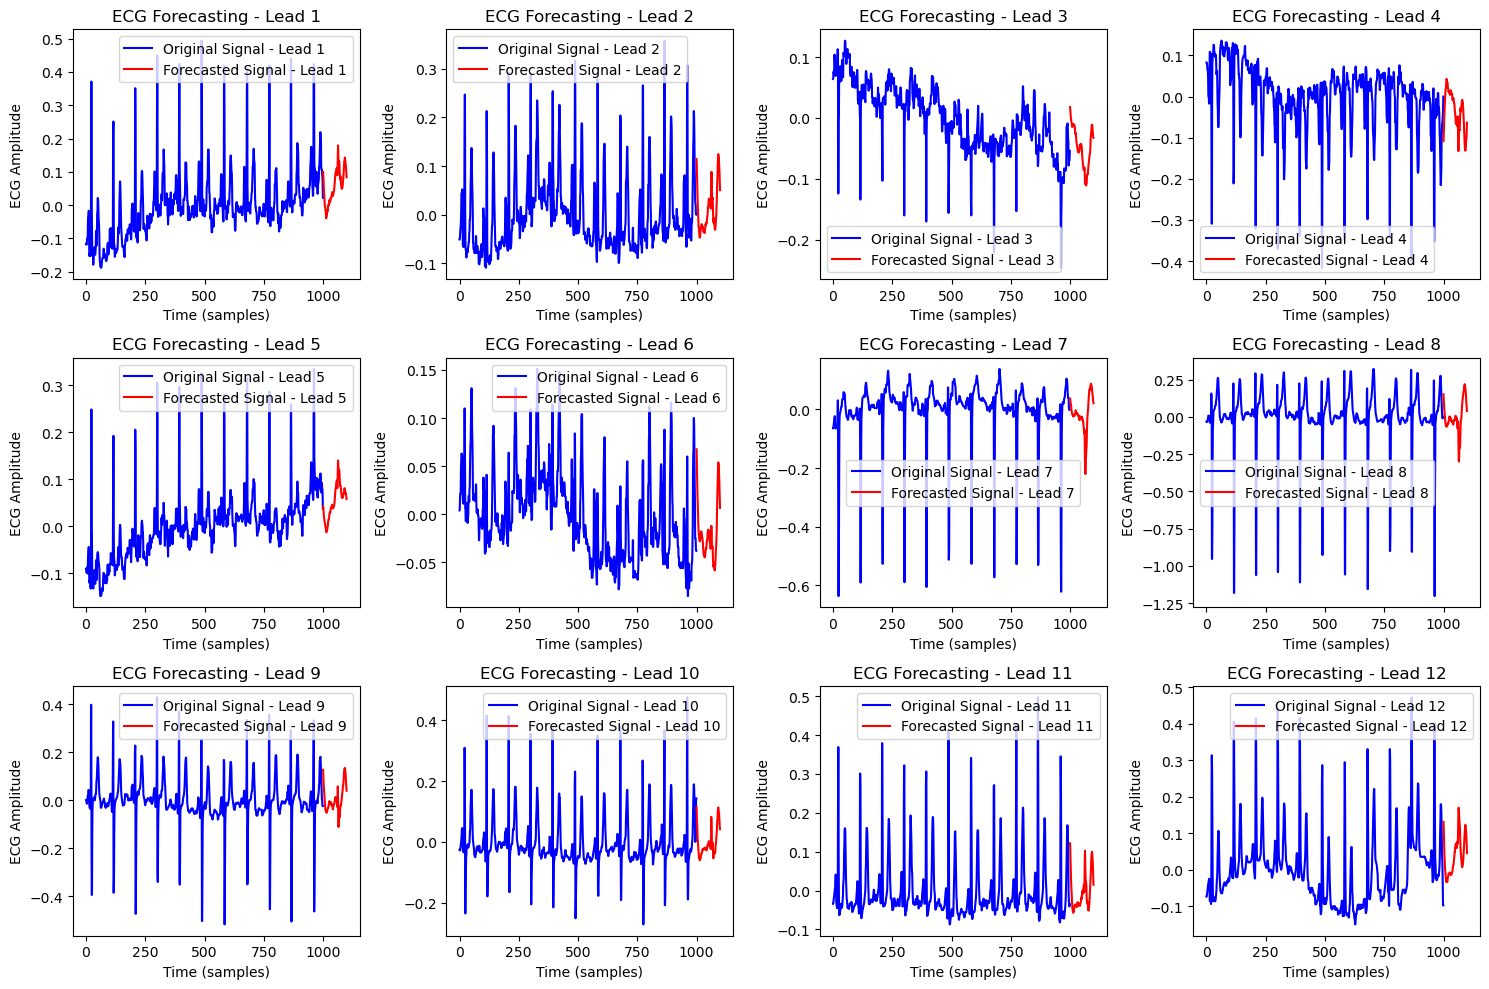

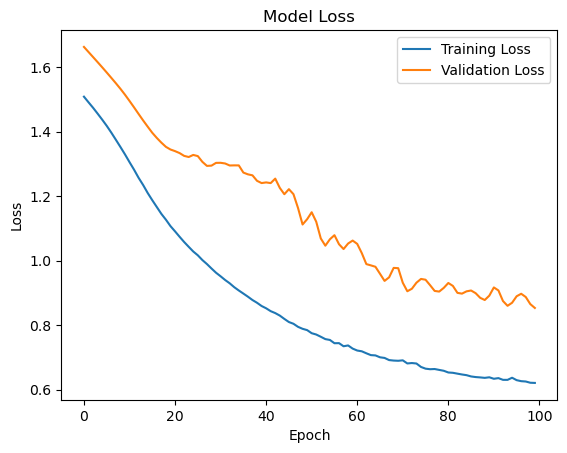

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 727ms/step
MAE: 0.6312500912572271
RMSE: 1.0589570423021264


In [2]:
import os
import pandas as pd
import numpy as np
import wfdb
import matplotlib.pyplot as plt
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv1D, MaxPooling1D, LSTM, Dense, Dropout, BatchNormalization
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from tensorflow.keras.callbacks import EarlyStopping
from scipy.signal import medfilt
from sklearn.metrics import mean_absolute_error, mean_squared_error

# Data Loading and Preprocessing
metadata_file = r"C:\Users\zain.hanif\Desktop\University\HIS Project\ptb-xl-a-large-publicly-available-electrocardiography-dataset-1.0.3\ptbxl_database.csv"  # Replace with your path
base_path = r"C:\Users\zain.hanif\Desktop\University\HIS Project\ptb-xl-a-large-publicly-available-electrocardiography-dataset-1.0.3"  # Replace with your path

df = pd.read_csv(metadata_file)
patient_id = 15709  # YOUR SPECIFIC PATIENT ID

df_patient = df[df['patient_id'] == patient_id]

ecg_data = []
for _, row in df_patient.iterrows():
    ecg_path_lr = os.path.join(base_path, row['filename_lr'])
    try:
        record = wfdb.rdrecord(ecg_path_lr.replace('.dat', ''))
        max_len = 2000
        actual_len = record.sig_len
        sampto = min(max_len, actual_len)
        record = wfdb.rdrecord(ecg_path_lr.replace('.dat', ''), sampto=sampto)
        ecg_signal_lr = record.p_signal[:, :12]
        ecg_data.append(ecg_signal_lr)
    except FileNotFoundError:
        print(f"File not found: {ecg_path_lr}")
    except ValueError as e:
        print(f"Error reading record {ecg_path_lr}: {e}")

if not ecg_data:
    print("No ECG data loaded for this patient. Please check the file paths and patient ID.")
    exit()

ecg_signal = np.array(ecg_data)
print(f"Loaded ECG signal shape for patient {patient_id}: {ecg_signal.shape}")

window_size = 800
forecast_horizon = 100

def create_forecasting_windows(ecg_signal, window_size, forecast_horizon):
    X, y = [], []
    num_records = ecg_signal.shape[0]
    time_steps = ecg_signal.shape[1]
    for record_idx in range(num_records):
        for i in range(time_steps - window_size - forecast_horizon):
            X.append(ecg_signal[record_idx, i: i + window_size])
            y.append(ecg_signal[record_idx, i + window_size: i + window_size + forecast_horizon])
    return np.array(X), np.array(y)

# --- Signal Filtering (Median Filter) ---
for i in range(ecg_signal.shape[0]):
    for j in range(12):
        ecg_signal[i, :, j] = medfilt(ecg_signal[i, :, j], kernel_size=3)

X, y = create_forecasting_windows(ecg_signal, window_size, forecast_horizon)

X = X.reshape(-1, window_size, 12)
y = y.reshape(-1, forecast_horizon * 12)

print(f"Generated {len(X)} windows for training.")
print(f"Shape of X: {X.shape}, Shape of y: {y.shape}")


X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

scaler_X = StandardScaler()
X_train = scaler_X.fit_transform(X_train.reshape(X_train.shape[0], -1)).reshape(X_train.shape)
X_test = scaler_X.transform(X_test.reshape(X_test.shape[0], -1)).reshape(X_test.shape)

scaler_y = StandardScaler()
y_train = scaler_y.fit_transform(y_train)
y_test = scaler_y.transform(y_test)



input_shape = (window_size, 12)

def build_cnn_lstm_model(input_shape, forecast_horizon):
    model = Sequential()
    model.add(Conv1D(filters=32, kernel_size=5, activation='relu', input_shape=input_shape))
    model.add(BatchNormalization())
    model.add(MaxPooling1D(pool_size=2))
    model.add(Conv1D(filters=64, kernel_size=3, activation='relu'))
    model.add(BatchNormalization())
    model.add(MaxPooling1D(pool_size=2))
    model.add(Dropout(0.4))

    model.add(LSTM(64, activation='tanh', return_sequences=True))
    model.add(Dropout(0.4))
    model.add(LSTM(32, activation='tanh'))

    model.add(Dense(128, activation='relu', kernel_regularizer='l2'))
    model.add(Dense(forecast_horizon * 12, activation='linear'))

    model.compile(optimizer='adam', loss='mse')
    return model

model = build_cnn_lstm_model(input_shape, forecast_horizon)

early_stopping = EarlyStopping(monitor='val_loss', patience=30, restore_best_weights=True)

history = model.fit(X_train, y_train, validation_data=(X_test, y_test),
                    epochs=100, batch_size=64,
                    callbacks=[early_stopping])

last_window = ecg_signal[0, -window_size:]
last_window = last_window[np.newaxis, ...]

last_window_scaled = scaler_X.transform(last_window.reshape(1, -1)).reshape(last_window.shape)

next_prediction = model.predict(last_window_scaled)

next_prediction = scaler_y.inverse_transform(next_prediction).reshape(forecast_horizon, 12)

plt.figure(figsize=(15, 10))
for i in range(12):
    plt.subplot(3, 4, i + 1)
    plt.plot(range(ecg_signal.shape[1]), ecg_signal[0, :, i], label=f"Original Signal - Lead {i+1}", color='blue')
    plt.plot(range(ecg_signal.shape[1], ecg_signal.shape[1] + forecast_horizon), next_prediction[:, i], label=f"Forecasted Signal - Lead {i+1}", color='red')
    plt.title(f"ECG Forecasting - Lead {i+1}")
    plt.xlabel("Time (samples)")
    plt.ylabel("ECG Amplitude")
    plt.legend()

plt.tight_layout()
plt.show()

plt.plot(history.history['loss'], label='Training Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.title('Model Loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend()
plt.show()

y_pred = model.predict(X_test)
y_pred = scaler_y.inverse_transform(y_pred)

mae = mean_absolute_error(y_test, y_pred)
rmse = np.sqrt(mean_squared_error(y_test, y_pred))

print(f"MAE: {mae}")
print(f"RMSE: {rmse}")

Loaded ECG signal shape: (1000, 12)
Generated 100 windows for training.
Shape of X: (100, 800, 12), Shape of y: (100, 1200)


C:\Users\zain.hanif\AppData\Local\anaconda3\Lib\site-packages\keras\src\layers\convolutional\base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Model: "sequential_56"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv1d_117 (Conv1D)             │ (None, 798, 32)        │         1,184 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling1d_117               │ (None, 399, 32)        │             0 │
│ (MaxPooling1D)                  │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv1d_118 (Conv1D)             │ (None, 397, 64)        │         6,208 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling1d_118               │ (None, 198, 64)        │             0 │
│ (MaxPooling1D)                  │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ lstm_23 (LSTM)                  │ (None, 64)             │        33,024 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_161 (Dense)               │ (None, 128)            │         8,320 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_162 (Dense)               │ (None, 64)             │         8,256 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_163 (Dense)               │ (None, 1200)           │        78,000 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 134,992 (527.31 KB)

 Trainable params: 134,992 (527.31 KB)

 Non-trainable params: 0 (0.00 B)

Epoch 1/50
3/3 ━━━━━━━━━━━━━━━━━━━━ 6s 420ms/step - loss: 0.0119 - val_loss: 0.0114
Epoch 2/50
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 175ms/step - loss: 0.0118 - val_loss: 0.0113
Epoch 3/50
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 149ms/step - loss: 0.0117 - val_loss: 0.0112
Epoch 4/50
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 140ms/step - loss: 0.0114 - val_loss: 0.0111
Epoch 5/50
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 141ms/step - loss: 0.0114 - val_loss: 0.0110
Epoch 6/50
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 150ms/step - loss: 0.0111 - val_loss: 0.0109
Epoch 7/50
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 148ms/step - loss: 0.0109 - val_loss: 0.0108
Epoch 8/50
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 152ms/step - loss: 0.0109 - val_loss: 0.0107
Epoch 9/50
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 161ms/step - loss: 0.0108 - val_loss: 0.0106
Epoch 10/50
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 147ms/step - loss: 0.0108 - val_loss: 0.0106
Epoch 11/50
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 134ms/step - loss: 0.0107 - val_loss: 0.0105
Epoch 12/50
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 138ms/step - loss: 0.0106 - val_lo

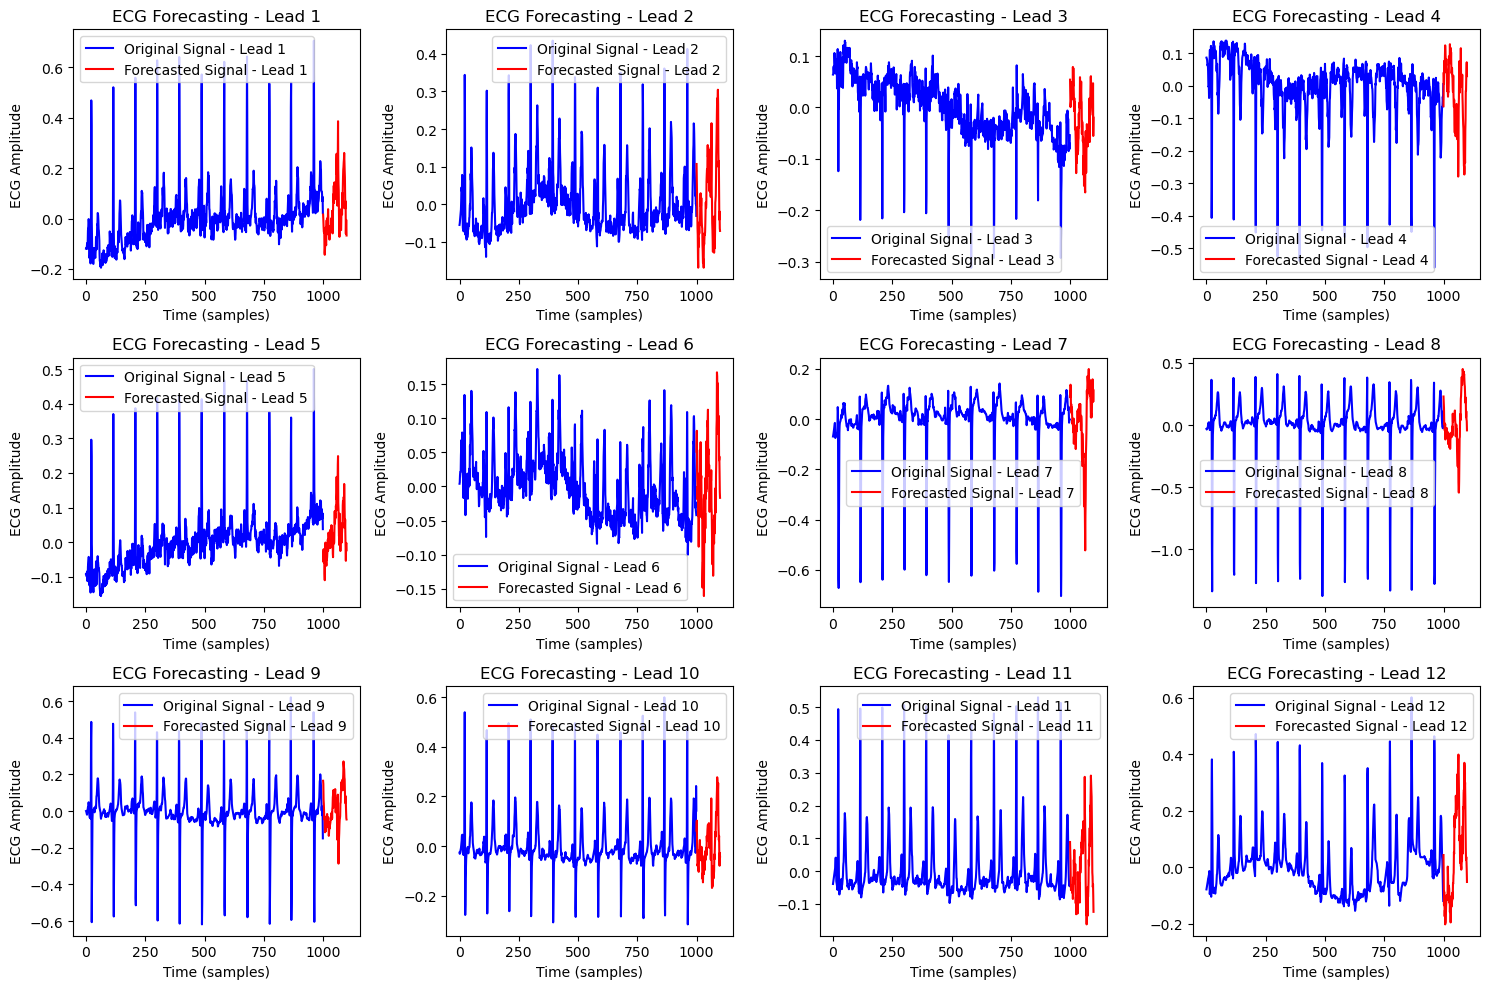

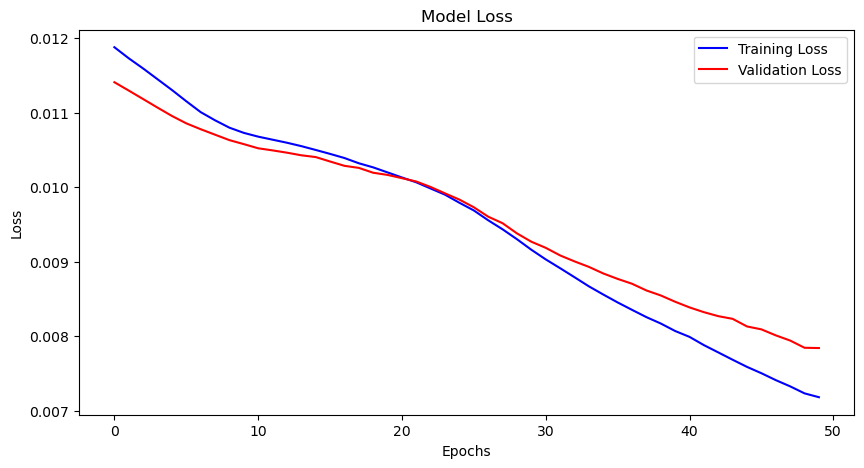

In [161]:
#CNN-LSTM MODEL 

import os
import pandas as pd
import numpy as np
import wfdb
import matplotlib.pyplot as plt
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv1D, MaxPooling1D, LSTM, Dense
from sklearn.model_selection import train_test_split

# Load and preprocess the ECG data
metadata_file = r"C:\Users\zain.hanif\Desktop\University\HIS Project\ptb-xl-a-large-publicly-available-electrocardiography-dataset-1.0.3\ptbxl_database.csv"
base_path = r"C:\Users\zain.hanif\Desktop\University\HIS Project\ptb-xl-a-large-publicly-available-electrocardiography-dataset-1.0.3"

df = pd.read_csv(metadata_file)
patient_id = 15709
df_patient = df[df['patient_id'] == patient_id]

ecg_data = []
for _, row in df_patient.iterrows():
    ecg_path_lr = os.path.join(base_path, row['filename_lr'])
    try:
        record = wfdb.rdrecord(ecg_path_lr.replace('.dat', ''), sampto=1000) 
        ecg_signal_lr = record.p_signal[:, :12] 
        ecg_data.append(ecg_signal_lr)
    except FileNotFoundError:
        print(f"File not found: {ecg_path_lr}")


if ecg_data:
    ecg_signal = np.array(ecg_data[0]) 
    print(f"Loaded ECG signal shape: {ecg_signal.shape}")
else:
    print("No ECG data loaded. Please check the file paths.")
    exit()

window_size = 800  
forecast_horizon = 100  

def create_forecasting_windows(ecg_signal, window_size, forecast_horizon):
    if len(ecg_signal) <= window_size + forecast_horizon:
        raise ValueError(f"Signal length ({len(ecg_signal)}) is too short for the given window size ({window_size}) "
                         f"and forecast horizon ({forecast_horizon}).")
    X, y = [], []
    for i in range(len(ecg_signal) - window_size - forecast_horizon):
        X.append(ecg_signal[i : i + window_size])  # Input window
        y.append(ecg_signal[i + window_size : i + window_size + forecast_horizon])  # Forecast target
    return np.array(X), np.array(y)

X, y = create_forecasting_windows(ecg_signal, window_size, forecast_horizon)

X = X 

# Reshape y to have the correct shape of (samples, forecast_horizon * 12)
y = y.reshape((y.shape[0], forecast_horizon * 12))

print(f"Generated {len(X)} windows for training.")
print(f"Shape of X: {X.shape}, Shape of y: {y.shape}")

# Build the CNN-LSTM model for 12 leads
def build_cnn_lstm_model(input_shape):
    model = Sequential()
    # CNN layers
    model.add(Conv1D(filters=32, kernel_size=3, activation='relu', input_shape=input_shape))
    model.add(MaxPooling1D(pool_size=2))
    model.add(Conv1D(filters=64, kernel_size=3, activation='relu'))
    model.add(MaxPooling1D(pool_size=2))
    
    # LSTM Layer - No Flatten before LSTM
    model.add(LSTM(64, activation='relu', return_sequences=False))
    
    # Dense layers
    model.add(Dense(128, activation='relu'))
    model.add(Dense(64, activation='relu'))
    model.add(Dense(forecast_horizon * 12, activation='linear'))  # Forecasting 12 leads for forecast horizon
    
    model.compile(optimizer='adam', loss='mse')
    return model

# Define input shape (window_size, 12 leads)
input_shape = (window_size, 12)
model = build_cnn_lstm_model(input_shape)
model.summary()

# Train the model
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)
history = model.fit(X_train, y_train, validation_data=(X_test, y_test), epochs=50, batch_size=32)

# Forecasting
last_window = ecg_signal[-window_size:]
last_window = last_window[np.newaxis, ...]  # Add batch dimension
# Ensure the shape of last_window is (1, window_size, 12)
next_prediction = model.predict(last_window)

# Reshape prediction to (forecast_horizon, 12) for visualization
next_prediction = next_prediction.reshape(forecast_horizon, 12)

# Visualization for all 12 leads
plt.figure(figsize=(15, 10))
for i in range(12):  # Plot each of the 12 leads
    plt.subplot(3, 4, i + 1)  # 3 rows, 4 columns of subplots
    plt.plot(range(len(ecg_signal)), ecg_signal[:, i], label=f"Original Signal - Lead {i+1}", color='blue')
    plt.plot(range(len(ecg_signal), len(ecg_signal) + forecast_horizon), next_prediction[:, i], label=f"Forecasted Signal - Lead {i+1}", color='red')
    plt.title(f"ECG Forecasting - Lead {i+1}")
    plt.xlabel("Time (samples)")
    plt.ylabel("ECG Amplitude")
    plt.legend()

plt.tight_layout()
plt.show()

# Plot training & validation loss values
plt.figure(figsize=(10, 5))
plt.plot(history.history['loss'], label='Training Loss', color='blue')
plt.plot(history.history['val_loss'], label='Validation Loss', color='red')
plt.title('Model Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.show()
